In [5]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [6]:
def get_data(ntrain, ntest):
    # amount of subsampling
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = scipy.io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]

    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]

    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

n_samples_train = 1000
n_samples_test = 200

x_train, y_train, x_test, y_test = get_data(n_samples_train, n_samples_test)

domain = x_train[1]
x_train = x_train[0]
x_test = x_test[0]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1000, 128) (1000, 128)
(200, 128) (200, 128)


In [26]:
x_low_dim = 10

model2 = second_model(x_low_dim = x_low_dim)

kernel = Matern(length_scale=np.ones(x_low_dim), nu=2.5) # RBF(np.ones(x_low_dim))
gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023)

y_pred = model2.train_test(x_train, x_test, y_train, gp)

Matern(length_scale=[8.25, 13.2, 14.7, 16.5, 22.4, 21.7, 29.5, 30.2, 43.6, 43.8], nu=2.5)
Matern(length_scale=[7.77, 18.6, 16, 14.9, 19.1, 25.1, 24.7, 24.3, 47.1, 41.6], nu=2.5)
Matern(length_scale=[17.8, 7.54, 14.8, 15.1, 21.4, 18, 27.6, 30.4, 44.9, 39], nu=2.5)
Matern(length_scale=[13.5, 8.94, 16, 13.4, 21.3, 20.2, 27.8, 28.3, 39.7, 39.4], nu=2.5)
Matern(length_scale=[14.5, 8.35, 16.4, 14.4, 19.3, 20.2, 29.8, 27.8, 42.5, 36.9], nu=2.5)
Matern(length_scale=[10.4, 9.42, 14.6, 14.4, 20.9, 23, 27.2, 25.6, 46.2, 43.8], nu=2.5)
Matern(length_scale=[15.1, 8.16, 16.6, 13.7, 18.7, 20.3, 28.4, 29.5, 47.7, 34.9], nu=2.5)
Matern(length_scale=[8.75, 11.1, 15.4, 14, 21.9, 21, 25.3, 29.2, 47.2, 46.9], nu=2.5)
Matern(length_scale=[8.43, 17.8, 14.9, 15.2, 20, 23.6, 24.6, 26, 41.9, 37], nu=2.5)
Matern(length_scale=[8.11, 15.1, 14.6, 15.5, 21.3, 21.5, 26.3, 29.6, 40.6, 43], nu=2.5)
Matern(length_scale=[12.1, 9.34, 15.8, 13.8, 20.8, 20.5, 25.2, 27.1, 42.7, 41.9], nu=2.5)
Matern(length_scale=[8.79, 12.4,

(200, 2, 128)
0.019600556495780914


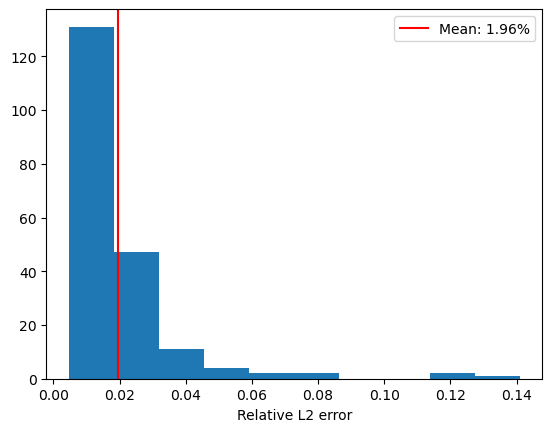

In [27]:
y_pred_mean = y_pred[:, 0, :]
y_pred_std = y_pred[:, 1, :]

print(y_pred.shape)
relative_L2 = np.linalg.norm(y_pred_mean - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(np.mean(relative_L2))

plt.figure()
plt.hist(relative_L2)
plt.axvline(np.mean(relative_L2), color = 'r', label = f"Mean: {round(np.mean(relative_L2)*100, 2)}%")
plt.xlabel("Relative L2 error")
plt.legend()
plt.show()

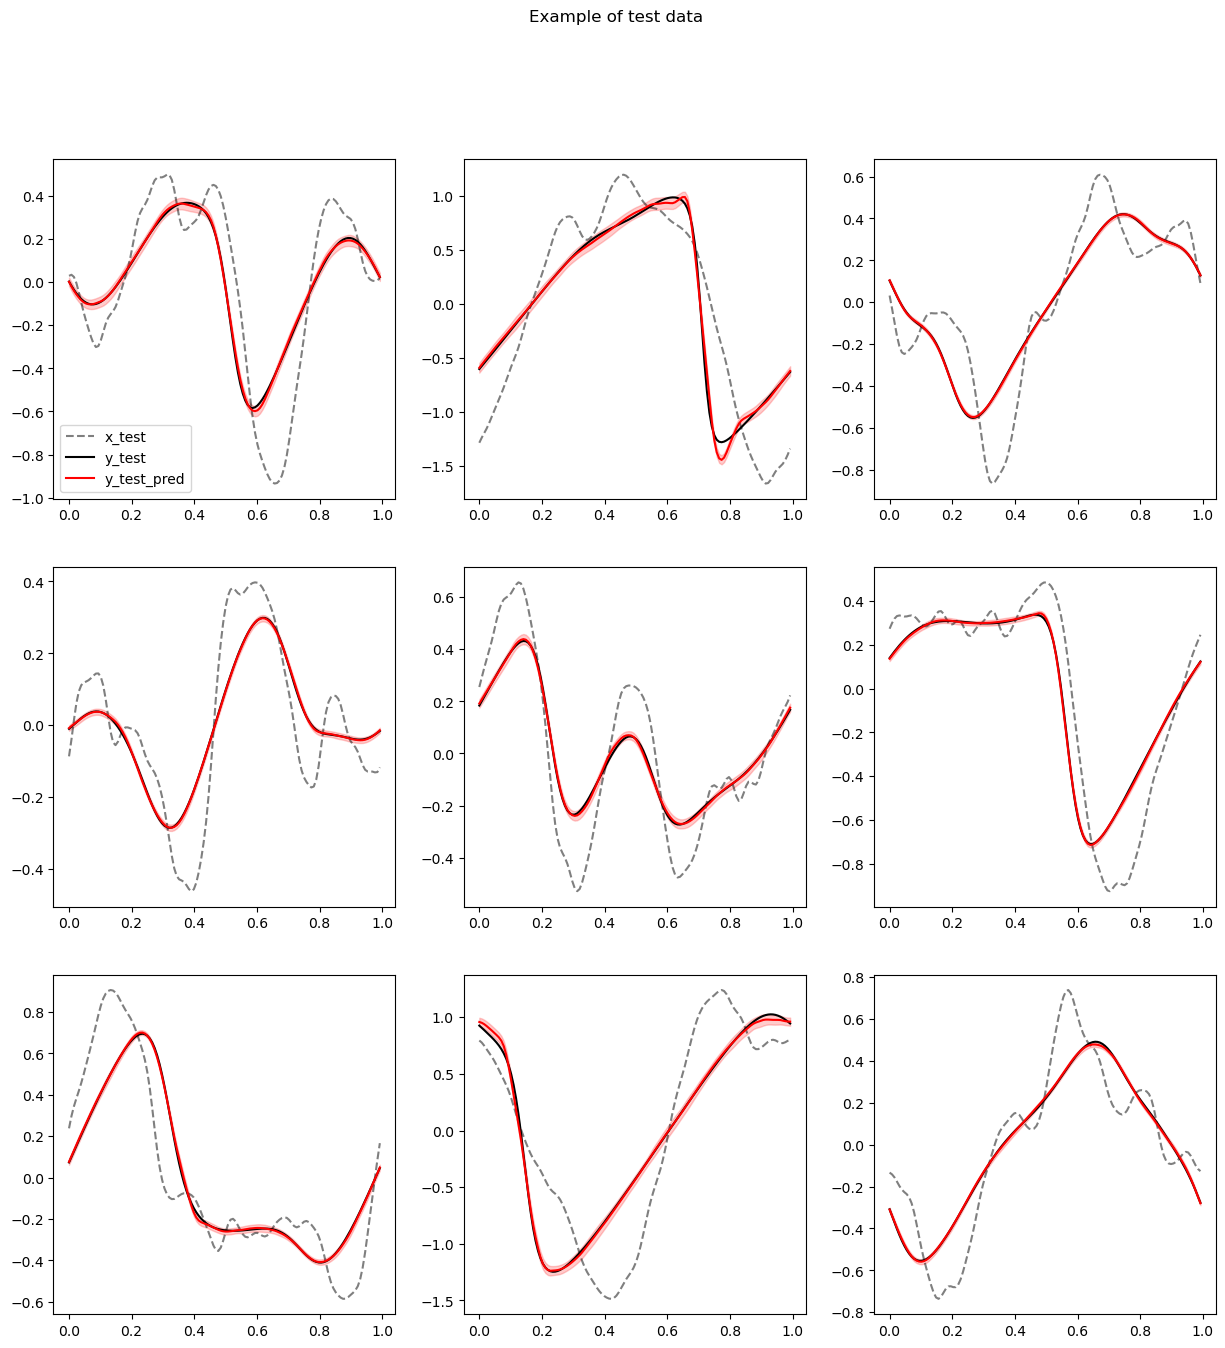

In [28]:
fig1, ax1 = plt.subplots(3, 3, figsize=(15, 15))
fig1.suptitle('Example of test data')
for i in range(9):
    ax = ax1[int(np.floor((i)/3)), int(i%3)]
    ax.plot(domain, x_test[i, :].T, label="x_test", linestyle='--', color='black', alpha=0.5)
    ax.plot(domain, y_test[i, :].T, label="y_test", color='black')
    ax.plot(domain, y_pred_mean[i, :].T, label="y_test_pred", color='red')
    ax.fill_between(domain[:, 0], y_pred_mean[i, :]-2*y_pred_std[i, :], y_pred_mean[i, :]+2*y_pred_std[i, :], color='red', alpha = 0.2)
    if i == 0:
        ax.legend()
    
plt.show()